<a href="https://colab.research.google.com/github/NunezKant/COVID19_MEX_MASTER/blob/master/Probabilistic_Fit_SEAIR_D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymc3==3.8

     |████████████████████████████████| 911kB 6.9MB/s 
     |████████████████████████████████| 1.5MB 33.4MB/s 
     |████████████████████████████████| 4.1MB 49.0MB/s 
     |████████████████████████████████| 337kB 46.5MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [0]:
%matplotlib inline
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns

import pymc3 as pm
from pymc3.ode import DifferentialEquation
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import arviz as az
import theano

In [0]:
def TimeSeriesLoader(url):
  df = pd.read_csv(url)

  df['Reporte'] = pd.to_datetime(df['Reporte'])
  df = (df.drop(["Procedencia", "Llegada","Inicio","Caso","Sexo","Edad","Confirmación"], axis=1)
          .dropna()
          .rename(columns = {"Reporte":"Dia"})
          .sort_values(by = ["Dia"])
          .reset_index(drop = True)
        )
  df["Casos_Acumulados"] = np.nan
  Estados = pd.DataFrame({
    "Estado":[],
    "Dia":[],
    "Casos_Acumulados":[]
  })

  for estado in df.Estado.unique():
      df.loc[(df.Estado == estado),"Casos_Acumulados"] =  np.arange(1,len(df.loc[(df.Estado == estado),"Casos_Acumulados"])+1,1)
      tmp = df.loc[df.Estado == estado].drop_duplicates("Dia", keep = 'last').reset_index(drop = True)
      Estados = pd.concat([Estados,tmp])
  return Estados

In [0]:
def SEAIR_M(y, t, p):
    """
    y[0] = S
    y[1] = E
    y[2] = A
    y[3] = I
    y[4] = R
    y[5] = D

    p[0] = Beta
    p[1] = Alpha
    p[2] = Gamma
    p[3] = Rho
    p[4] = Kappa

    St = S[-1] - (beta*S[-1]*I[-1])*dt
    Et = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt
    At = A[-1] + (1-rho)*(alpha*E[-1] - gamma*A[-1])*dt
    It = I[-1] + rho*(alpha*E[-1] - gamma*I[-1])*dt
    Dt = kappa*I[-1]
    Rt = 1 - (S[-1]+E[-1]+A[-1]+I[-1]-D[-1])
    """


    ds = -p[0]*y[0]*y[3]
    de = p[0]*y[0]*y[3] - p[1]*y[1]
    da = (1-p[3])*(p[1]*y[1] - p[2]*y[2])
    di = p[3]*(p[1]*y[1] - p[2]*y[3])
    dm = p[4]*y[3]      
    dr = 1- (y[0]+y[1]+y[2]+y[3]+y[5])
    return [ds, de, da, di, dr, dm]



In [0]:
def getDays(estado,FirstDay,dt):
  days = Estados.loc[Estados.Estado == estado,"Dia"].dt.day.values
  days = (days - FirstDay)* (1/dt)
  return days

In [0]:
def InitialConditions_Day(Population,i,r,d):
  """ 
  Produce los datos normalizados de S,E,I,R dados I y R del dia.
  """
  I = i / Population  # Tenemos 32 casos
  E = (i*4)/ Population # Asumimos 4 expuestos por caso
  A = np.round(i*.18,0)/Population
  D = d # No Muertos
  S = (1) - (E_o+I_o+A_o+D_o) # El resto somos suceptibles
  R = r # NO hay ningun recuperado
  return [S, E, A, I, R, D]

def Construct_ObsVector(Iobs,pop,r,d):
  yobs_vector = np.empty((0,len(Iobs)*6))
  for obs in Iobs:
    CI = InitialConditions_Day(pop,obs,r,d)
    yobs_vector = np.append(yobs_vector,CI)
  return yobs_vector.reshape(len(Iobs),6)

# CON DT de un día

In [0]:
np.random.seed(666)

#(2020-03-14)
Population = 8000000
I_o = 2 / Population  # Tenemos 32 casos
E_o = (2*4)/ Population # Asumimos 4 expuestos por caso
A_o = 0
D_o = 0 # No Muertos
S_o = (1) - (E_o+I_o+A_o+D_o) # El resto somos suceptibles
R_o = 0 # NO hay ningun recuperado

dias_evaluacion = 120
dt=1
periodo_evaluacion = np.arange(0,dias_evaluacion+dt,dt)

R_o = 3.5 #Escenario Base
alpha = 0.2
gamma = 0.5
rho = 0.82
kappa = .016
beta = R_o * gamma

y0 = np.array([S_o,E_o,A_o,I_o,R_o,D_o])

args = ((beta, alpha, gamma, rho,kappa,),)
 
y = odeint(SEAIR_M,t=periodo_evaluacion,y0=y0, args=args, rtol=1e-08)

In [0]:
Estados = TimeSeriesLoader("https://gist.githubusercontent.com/said3427/18f39eab460766a17ea4802607dd5522/raw")

In [0]:
Estados.loc[Estados.Estado == "Jalisco"]
yobs = Estados.loc[Estados.Estado == "Jalisco","Casos_Acumulados"].values
date  = Estados.loc[Estados.Estado == "Jalisco","Dia"].values

days = getDays("Jalisco",14,dt)

In [77]:
days

array([ 0.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 12., 13., 14.])

In [78]:
np.arange(0,days[-1]+1,1)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14.])

In [0]:
from scipy.interpolate import InterpolatedUnivariateSpline
interp = InterpolatedUnivariateSpline(days,yobs,k=2)

Text(0.5, 0, 'Dias')

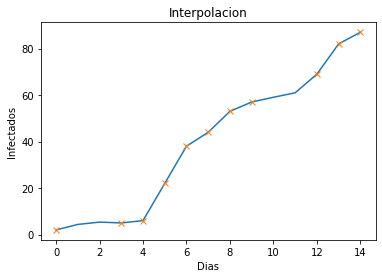

In [72]:
y_interp = interp(np.arange(0,days[-1]+1,1))
plt.plot(np.arange(0,days[-1]+1,1),y_interp)
plt.plot(days,yobs,"x")
plt.title("Interpolacion")
plt.ylabel("Infectados")
plt.xlabel("Dias")

In [0]:
yobs_vector = Construct_ObsVector(y_interp,Population,0,0)

In [195]:
for obs in yobs_vector:
  print(obs.sum())

1.0
1.0000015996483098
1.0000022246483098
1.0000019999999998
1.000002625
1.000013
1.000023375
1.00002725
1.0000331249999999
1.000035625
1.000037022450596
1.0000382307752438
1.000043375
1.000051875
1.0000551250000003


In [181]:
y_interp

array([ 2.        ,  4.3594373 ,  5.3594373 ,  5.        ,  6.        ,
       22.        , 38.        , 44.        , 53.        , 57.        ,
       59.03592095, 60.96924039, 69.        , 82.        , 87.        ])

In [0]:
SEAIRM_model = DifferentialEquation(
    func=SEAIR_M,
    times=periodo_evaluacion[:int(days[-1]+1)], 
    n_states=6,
    n_theta=5,
)

In [184]:
with pm.Model() as model3:
    
    alpha = 0.2
    gamma = 0.5
    rho = 0.82
    kappa = .016
    
    
    sigma = pm.HalfCauchy('sigma', 0.5)
    R0 = pm.Bound(pm.Normal, lower=1, upper =5)('R0',3, 0.7)
    p_beta = pm.Deterministic('beta', gamma*R0)

    """
    p[0] = Beta
    p[1] = Alpha
    p[2] = Gamma
    p[3] = Rho
    p[4] = Kappa

    Estoy dejando fijos los demas parámetros, por ahora, dado que hay muy pocas observaciones de infectados confirmados
    """

    prior = pm.sample_prior_predictive()
    SEAIRM_curves = SEAIRM_model(y0=y0, theta=[p_beta, alpha, gamma, rho, kappa])
    Y = pm.Normal('Y', mu=SEAIRM_curves, sd=sigma, observed=yobs_vector)

    trace = pm.sample(2000,tune=1000, target_accept=0.9, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [R0, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [44:50<00:00,  2.23draws/s]


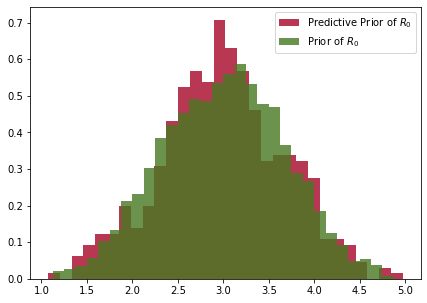

In [185]:
plt.figure(figsize = (7,5))
plt.hist(prior["R0"],histtype="stepfilled",bins=30,alpha = .80, label = f"Predictive Prior of $R_0$",color = "#A60628", density = True)
plt.hist(trace["R0"],histtype="stepfilled",bins=30,alpha = .80, label = f"Prior of $R_0$",color = "#467821", density = True)
plt.legend()

In [186]:
print(prior["R0"].mean())
print(prior["R0"].std()) # Al parecer no fittea

2.9968862815239663
0.6771158546203525


In [187]:
ppc_samples = pm.sample_posterior_predictive(trace, samples=4000, model=model3)

100%|██████████| 4000/4000 [05:30<00:00, 12.11it/s]


In [0]:
ppc_samples = ppc_samples['Y']

In [0]:
mean_ppc = ppc_samples.mean(axis=0)
CriL_ppc = np.percentile(ppc_samples,q=2.5,axis=0)
CriU_ppc = np.percentile(ppc_samples,q=97.5,axis=0)

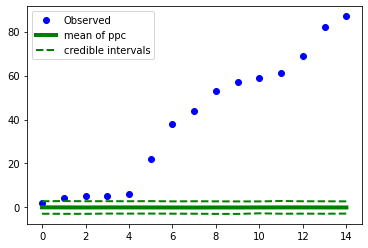

In [192]:
plt.plot(periodo_evaluacion[:int(days[-1]+1)],y_interp,'o', color='b', lw=1, label='Observed')
plt.plot(periodo_evaluacion[:int(days[-1]+1)],mean_ppc[:,3], color='g', lw=4, label='mean of ppc')
plt.plot(periodo_evaluacion[:int(days[-1]+1)],CriL_ppc[:,3], '--',  color='g', lw=2, label='credible intervals')
plt.plot(periodo_evaluacion[:int(days[-1]+1)],CriU_ppc[:,3], '--',  color='g', lw=2)
plt.legend()

In [145]:
mean_ppc[:15,3]

array([-1.66225783,  0.79123137,  2.03495961, -0.79692447,  0.46472957,
        0.51907446, -0.11942749, -0.51937397, -0.83227977, -1.13032718,
       -1.71540373, -1.5685632 ,  1.30360598, -1.35661789,  0.17757513])